# PPO with MLP - Closing Price

In [1]:
import numpy as np
import yfinance as yf
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import random
import matplotlib.dates as mdates
import pandas as pd

In [116]:
tickers = ["AAPL","MSFT","GOOGL","META","AMZN", "TSLA", "NVDA"]

data = {}
for t in tickers:
    df = yf.download(t, start="2020-01-01", end="2023-01-01")
    closes = df["Close"].values.astype(np.float32)
    mu, sigma = closes.mean(), closes.std()
    data[t] = {
        "dates": df.index,
        "raw":    closes,
        "norm":  (closes - mu) / sigma
    }

raw_prices = { t: data[t]["raw"]  for t in tickers }
normalized_prices = { t: data[t]["norm"] for t in tickers }

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### PPO for multiple stocks

In [212]:
state_dim   = 5  # window size 
action_dim  = 1    
lr          = 3e-4
gamma       = 0.9
lam         = 0.95
clip_eps    = 0.2
epochs      = 50
batch_size  = 32
l2_lambda   = 1e-4


# build multi‐stock timeseries states
state_window = state_dim
states, next_states, rewards, dones = [], [], [], []

num_days = len(normalized_prices[tickers[0]]) - state_window - 1

for day in range(num_days):
    s_day, ns_day, r_day = [], [], []
    
    for t in tickers:
        arr = normalized_prices[t]
        
        s_day .append(arr[day:day+state_window])
        ns_day.append(arr[day+1:day+1+state_window])
        r_day .append((arr[day+state_window+1] - arr[day+state_window]).item())
        
        states     .append(s_day)
        next_states.append(ns_day)
        rewards    .append(r_day)
        dones      .append([0.0] * len(tickers))
    
# convert to tensors 
states      = torch.tensor(np.array(states),      dtype=torch.float32)
next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
rewards     = torch.tensor(np.array(rewards),     dtype=torch.float32)
dones       = torch.tensor(np.array(dones),       dtype=torch.float32)


# Neural Network 
# initialising weights 
w1  = torch.nn.Parameter(torch.randn(state_dim, 64) * 0.1, requires_grad=True)
w2  = torch.nn.Parameter(torch.randn(64, 32) * 0.1, requires_grad=True)
w3a = torch.nn.Parameter(torch.randn(32, action_dim) * 0.1, requires_grad=True)
w3c = torch.nn.Parameter(torch.randn(32, 1) * 0.1, requires_grad=True)
log_std = torch.nn.Parameter(torch.full((action_dim,), -1.0))  # ~std of 0.37

# L2 & optimizer
optimizer = torch.optim.Adam([
    {'params': [w1, w2, w3a, w3c], 'weight_decay': l2_lambda},
    {'params': [log_std], 'weight_decay': 0.0}], lr=lr)

# MLP forward
def mlp_forward(x, w1, w2, w3):
    h1 = F.relu(x @ w1)
    h2 = F.relu(h1 @ w2)
    return h2 @ w3


# Sample actions
# UPDATED: inputs w1, w2a, log_std so they can be accessed by the environment 
def get_action(state, w1, w2, w3a, log_std):
    mean     = mlp_forward(s, w1, w2, w3a)
    std      = log_std.exp()
    dist     = torch.distributions.Normal(mean, std)
    action   = dist.sample()
    action = torch.clamp(dist.sample(), -0.5, 0.5)
    log_prob = dist.log_prob(action).sum(axis=-1)
    return action, log_prob

# Collect trajectories (days × stocks) 
with torch.no_grad():
    all_actions   = []
    all_log_probs = []
    all_values    = []

    for day in range(len(states)):            # 1) loop over days
        for stock in range(states.size(1)):  # 2) inner loop over 5 stocks
            s = states[day, stock].view(1, -1)
            a, lp = get_action(s, w1, w2, w3a, log_std)
            v = mlp_forward(s, w1, w2, w3c)

            all_actions  .append(a)
            all_log_probs.append(lp)
            all_values   .append(v)

    # bootstrap final values for each stock
    for stock in range(next_states.size(1)):
        s_final = next_states[-1, stock].view(1, -1)
        all_values.append(mlp_forward(s_final, w1, w2, w3c))

# reshape into tensors
actions   = torch.cat(all_actions).view(len(states), -1, action_dim)
log_probs = torch.stack(all_log_probs).view(len(states), -1)
values    = torch.stack(all_values).view(len(states)+1, states.size(1))

# GAE calculation
advantages = torch.zeros_like(rewards)
for stock in range(states.size(1)):
    last_adv = 0
    for t in reversed(range(len(states))):
        delta    = rewards[t,stock] \
                   + gamma * values[t+1,stock] * (1 - dones[t,stock]) \
                   - values[t,stock]
        last_adv = delta + gamma * lam * (1 - dones[t,stock]) * last_adv
        advantages[t,stock] = last_adv
returns = advantages + values[:-1]

# flatten transitions for PPO
flat_states  = states.view(-1, state_dim)
flat_actions = actions.view(-1, action_dim)
flat_lp_old  = log_probs.view(-1)
flat_ret     = returns.view(-1)
flat_adv     = advantages.view(-1)

def get_params_vector(w1, w2, w3a):
    return torch.cat([w1.flatten(), w2.flatten(), w3a.flatten()])

# sample a small fixed batch of states for correlation testing
n_val = min(100, flat_states.size(0))
perm = torch.randperm(flat_states.size(0))
fixed_states = flat_states[perm[:n_val]]

policy_changes      = []
action_correlations = []

prev_params_vec   = None
prev_action_means = None

# compute number of mini‑batches per epoch
n_trans   = flat_states.size(0)

n_batches = math.ceil(n_trans / batch_size)

actor_loss_hist  = []
critic_loss_hist =  []
reward_hist      = []
entropy_hist      = []
logprob_hist      = []
logprob_ratio_hist = []


# PPO training
for epoch in range(epochs):
    perm = torch.randperm(n_trans)
    epoch_actor_loss  = 0.0
    epoch_critic_loss = 0.0
    epoch_reward      = 0.0
    epoch_entropy     = 0.0
    epoch_logprob     = 0.0
    epoch_log_ratio = 0.0

    
    for batch_idx, start in enumerate(range(0, n_trans, batch_size), start=1):
        idx          = perm[start:start+batch_size]
        state_batch  = flat_states[idx]
        action_batch = flat_actions[idx].unsqueeze(1)
        old_logps_b  = flat_lp_old[idx].detach()
        return_batch = flat_ret[idx].detach()
        adv_batch    = flat_adv[idx].detach()

        # actor
        mean     = mlp_forward(state_batch, w1, w2, w3a)
        std      = log_std.exp()
        dist     = torch.distributions.Normal(mean, std)
        new_lps  = dist.log_prob(action_batch).sum(axis=-1)

        log_ratio = (new_lps - old_logps_b).mean()
        epoch_log_ratio += log_ratio.item()


        ratio    = (new_lps - old_logps_b).exp()
        clipped  = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * adv_batch
        actor_loss = -torch.min(ratio * adv_batch, clipped).mean()

        # record entropy & log‐prob stats for this batch
        batch_entropy = dist.entropy().sum(axis=-1).mean()       # average entropy over batch
        batch_logprob = new_lps.mean()                          # average log‐prob over batch
        epoch_entropy += batch_entropy.item()
        epoch_logprob += batch_logprob.item()

        # critic
        value_pred  = mlp_forward(state_batch, w1, w2, w3c).squeeze(-1)
        critic_loss = F.mse_loss(value_pred, return_batch)

        loss = actor_loss + 0.5 * critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_actor_loss  += actor_loss.item()
        epoch_critic_loss += critic_loss.item()
        epoch_reward      += return_batch.mean().item()
        

    curr_vec = get_params_vector(w1, w2, w3a).detach()
    if prev_params_vec is not None:
        Δ = (curr_vec - prev_params_vec).norm().item()
    else:
        Δ = 0.0
    policy_changes.append(Δ)
    prev_params_vec = curr_vec
    
    actor_loss_hist .append(epoch_actor_loss  / n_batches)
    critic_loss_hist.append(epoch_critic_loss / n_batches)
    reward_hist     .append(epoch_reward      / n_batches)
    entropy_hist    .append(epoch_entropy     / n_batches)
    logprob_hist    .append(epoch_logprob     / n_batches)
    logprob_ratio_hist.append(epoch_log_ratio / n_batches)
    






In [105]:
torch.save({
    'w1': w1,
    'w2': w2,
    'w3a': w3a,
    'w3c': w3c,
    'log_std': log_std
}, 'MLP_model_cp_1.pth')


In [ ]:
epochs_range = list(range(1, epochs+1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# 5.3.1 Actor Loss Over Epochs
ax1.plot(epochs_range, actor_loss_hist, marker='o')
ax1.set_title("Actor Loss Over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Actor Loss")
ax1.grid(True)

# 5.3.3 Log-Probability of Actions
ax2.plot(epochs_range, logprob_hist, marker='o', color='tab:green')
ax2.set_title("Average Log-Probability Over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Avg. Log-Probability")
ax2.grid(True)

plt.tight_layout()
#plt.savefig("actor_loss_and_logprob.png", dpi=600)
plt.show()


### Trading Environment 

In [172]:
class MultiStockEnvironment:
    def __init__(self, raw_prices, window_size, initial_cash=10000):
        self.raw_prices   = raw_prices
        self.window_size  = window_size
        self.initial_cash = float(initial_cash)
        self.tickers      = list(raw_prices.keys())
        self.reset()

    def reset(self):
        self.t = 0
        self.cash = self.initial_cash
        self.holdings = {t: 0.0 for t in self.tickers}
        self.portfolio_values = [self.initial_cash]
        self.done = False

        return {
            t: self.raw_prices[t][0:self.window_size]
            for t in self.tickers
        }

    def step(self, actions):
        # Liquidate negatives
        freed_cash = 0.0
        for t in self.tickers:
            if actions[t] < 0 and self.holdings[t] > 0:
                price = self.raw_prices[t][self.t + self.window_size].item()
                freed_cash += self.holdings[t] * price
                self.holdings[t] = 0.0
        self.cash += freed_cash

        # Allocate positives
        pos_actions = {t: actions[t] for t in self.tickers if actions[t] > 0}
        total_pos   = sum(pos_actions.values())
        if total_pos > 0 and self.cash > 0:
            for t, a in pos_actions.items():
                weight = a / total_pos
                price = self.raw_prices[t][self.t + self.window_size].item()
                buy_amount = self.cash * weight
                self.holdings[t] += buy_amount / price
            self.cash = 0.0

        # Compute portfolio value
        pv = self.cash
        for t in self.tickers:
            price = self.raw_prices[t][self.t + self.window_size].item()
            pv += self.holdings[t] * price
        self.portfolio_values.append(pv)

        # Advance time
        self.t += 1
        if self.t + self.window_size >= len(next(iter(self.raw_prices.values()))):
            self.done = True

        # Next state
        next_states = None
        if not self.done:
            next_states = {
                t: self.raw_prices[t][self.t : self.t + self.window_size]
                for t in self.tickers
            }

        return next_states, pv, self.done, {}


### buy and hold

In [175]:
class BuyAndHoldEnvironment:
    def __init__(self, raw_prices, initial_cash=10000):
        self.raw_prices = raw_prices
        self.initial_cash = initial_cash
        self.portfolio_values = []

    def run(self, start_index=10):
        # stack into shape (T,5)
        prices = np.stack([self.raw_prices[t] for t in tickers], axis=1)
        # equal allocation
        alloc = self.initial_cash / len(tickers)
        init_p = prices[start_index]            # [5,]
        shares = alloc / init_p                 # [5,]
        # build PV curve
        for p in prices[start_index+1:]:
            self.portfolio_values.append((shares * p).sum())

### Simulate Agent with the trained MLP once 

In [186]:
# Precompute price normalization stats 
mean_price = {t: raw_prices[t].mean() for t in tickers}
std_price  = {t: raw_prices[t].std()  for t in tickers}

# Instantiate the environment 
env = MultiStockEnvironment(raw_prices, window_size=state_dim)
state_dict = env.reset()

day = 0
print("Starting multi-stock simulation...\n")

while not env.done:
    # Normalize state and sample actions
    actions = {}
    trades  = {}
    for t in tickers:
        win    = state_dict[t]  # price window of length state_dim
        norm_p = (win - mean_price[t]) / std_price[t]
        st     = torch.tensor(norm_p, dtype=torch.float32).view(1, -1)

        a_tensor, _ = get_action(st, w1, w2, w3a, log_std)
        a_val       = a_tensor.item()
        actions[t]  = a_val

        if   a_val > 0 and env.holdings[t] == 0:
            trades[t] = "BUY"
        elif a_val < 0 and env.holdings[t] > 0:
            trades[t] = "SELL"
        else:
            trades[t] = "HOLD"

    # Step the environment
    next_states, port_val, done, _ = env.step(actions)

    # Log values
    cash = float(env.cash)
    prices = {t: float(raw_prices[t][day + state_dim]) for t in tickers}
    held   = {t: float(env.holdings[t]) for t in tickers}

    # Print summary and per-ticker details
    print(f"Day {day}: Cash = {cash:.2f}, Portfolio = {port_val:.2f}")
    for t in tickers:
        print(f"  {t:>6s} | Price = {prices[t]:6.2f} | "
              f"Action = {actions[t]:6.4f} | Trade = {trades[t]:>4s} | "
              f"Held = {held[t]:6.4f}")
    print("-" * 60)

    # advance
    state_dict = next_states
    day += 1

print(f"\nDone. Final portfolio value: {env.portfolio_values[-1]:.2f}")


Starting multi-stock simulation...

Day 0: Cash = 0.00, Portfolio = 10000.00
    AAPL | Price =  74.96 | Action = -0.5000 | Trade = HOLD | Held = 0.0000
    MSFT | Price = 154.73 | Action = 0.3081 | Trade =  BUY | Held = 19.4363
   GOOGL | Price =  70.65 | Action = 0.3366 | Trade =  BUY | Held = 46.5100
    META | Price = 217.28 | Action = -0.5000 | Trade = HOLD | Held = 0.0000
    AMZN | Price =  95.05 | Action = -0.5000 | Trade = HOLD | Held = 0.0000
    TSLA | Price =  32.09 | Action = -0.1693 | Trade = HOLD | Held = 0.0000
    NVDA | Price =   6.05 | Action = 0.3797 | Trade =  BUY | Held = 612.7157
------------------------------------------------------------
Day 1: Cash = 0.00, Portfolio = 10027.13
    AAPL | Price =  75.13 | Action = 0.5000 | Trade =  BUY | Held = 11.2383
    MSFT | Price = 154.01 | Action = 0.5000 | Trade = HOLD | Held = 24.9188
   GOOGL | Price =  71.11 | Action = 0.2067 | Trade = HOLD | Held = 51.4189
    META | Price = 217.04 | Action = -0.4676 | Trade = HOLD 

/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_1556/879226290.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prices = {t: float(raw_prices[t][day + state_dim]) for t in tickers}


Day 33: Cash = 0.00, Portfolio = 9926.35
    AAPL | Price =  66.38 | Action = -0.4632 | Trade = SELL | Held = 0.0000
    MSFT | Price = 151.41 | Action = 0.5000 | Trade =  BUY | Held = 11.4939
   GOOGL | Price =  65.43 | Action = -0.1235 | Trade = HOLD | Held = 0.0000
    META | Price = 188.86 | Action = 0.0008 | Trade = HOLD | Held = 8.7414
    AMZN | Price =  94.21 | Action = -0.4586 | Trade = HOLD | Held = 0.0000
    TSLA | Price =  45.27 | Action = 0.5000 | Trade = HOLD | Held = 134.9474
    NVDA | Price =   6.29 | Action = 0.1226 | Trade =  BUY | Held = 67.7981
------------------------------------------------------------
Day 34: Cash = 0.00, Portfolio = 9922.60
    AAPL | Price =  66.34 | Action = 0.2735 | Trade =  BUY | Held = 3.3995
    MSFT | Price = 155.07 | Action = -0.5000 | Trade = SELL | Held = 0.0000
   GOOGL | Price =  66.64 | Action = 0.5000 | Trade =  BUY | Held = 6.1866
    META | Price = 191.57 | Action = 0.3881 | Trade = HOLD | Held = 10.4117
    AMZN | Price =  94.

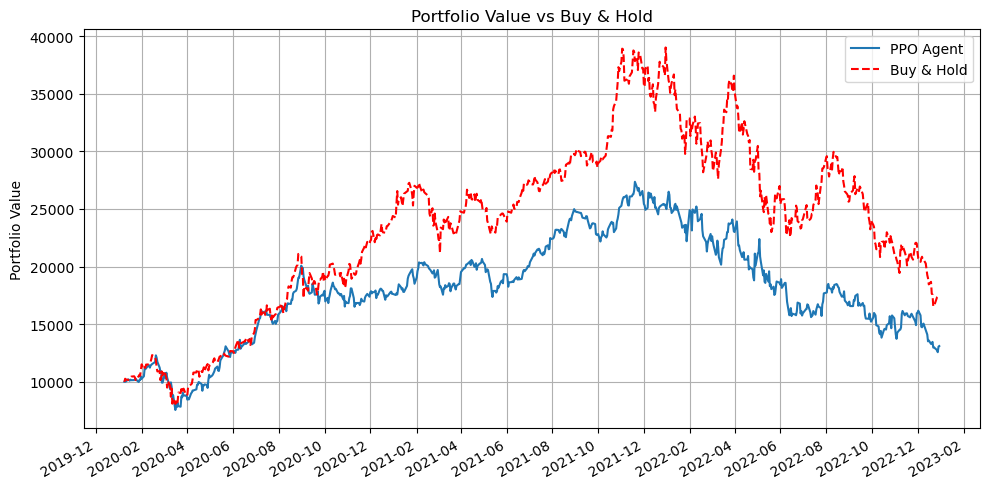

In [188]:

dates = data[tickers[0]]["dates"]          # pandas.DatetimeIndex of length T_raw

# 2) Compute how many points in your PPO curve
ppo_curve = env.portfolio_values           # list of length L_ppo
L_ppo     = len(ppo_curve)

# 3) Align the dates: the first PPO value corresponds to having seen the first `state_dim` days,
#    so we map it to `dates[state_dim-1]`
start_idx = state_dim - 1
ppo_dates = dates[start_idx : start_idx + L_ppo]

# 4) Do the same for Buy & Hold
bh = BuyAndHoldEnvironment(raw_prices)
bh.run(start_index=state_dim)
bh_curve  = bh.portfolio_values            # also length L_ppo (or pad/truncate if needed)
bh_dates  = dates[start_idx : start_idx + len(bh_curve)]

# 5) Plot them
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ppo_dates, ppo_curve, label="PPO Agent")
ax.plot(bh_dates,  bh_curve, 'r--', label="Buy & Hold")

ax.set_title("Portfolio Value vs Buy & Hold")
ax.set_ylabel("Portfolio Value")
ax.legend()
ax.grid(True)

# Format x‐axis as dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate()

plt.tight_layout()
plt.savefig("MLP_CP_DATES_7", dpi=600)
plt.show()


remove the interpolation - and add a heatmap of normalised prices

### Run the Environment 50 times to get an average on how the MLP is performing

/var/folders/1b/2dv3_3nx66s3980gg6hg5g1m0000gn/T/ipykernel_1556/182613744.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("MLP_Closing/MLP_model

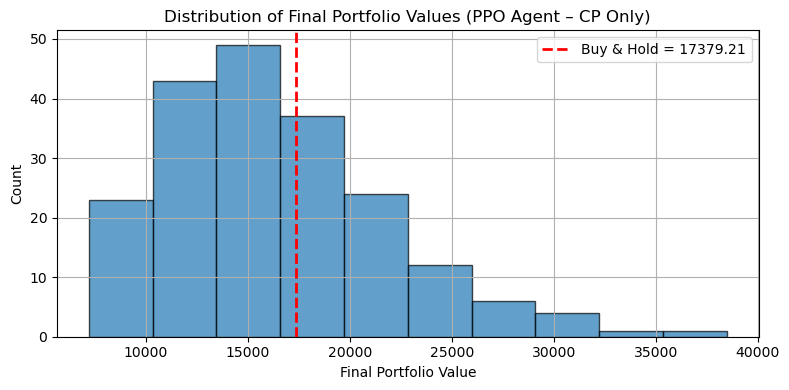

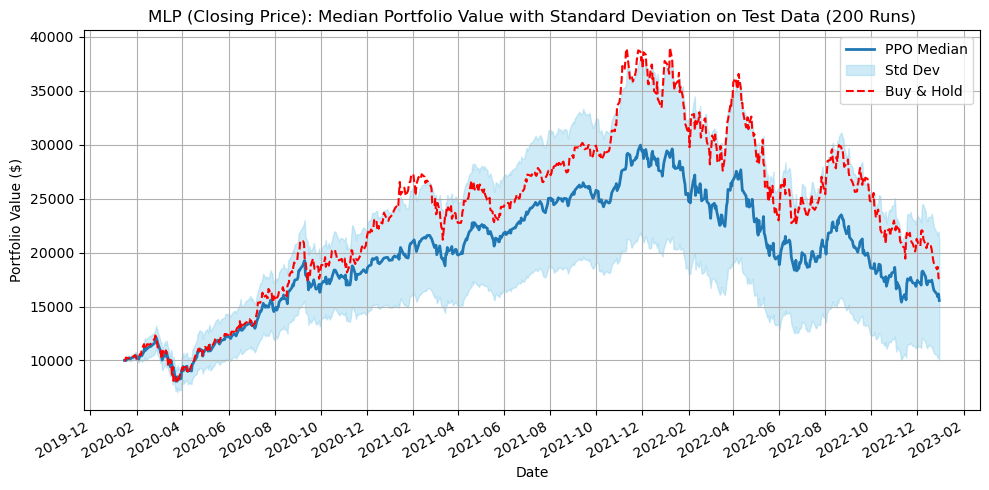

In [128]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pickle
import torch.nn.functional as F
import os

tickers = ["AAPL", "MSFT", "GOOGL", "META", "AMZN", "TSLA", "NVDA"]

n_runs = 200

# === Define MLP weights ===
w1 = torch.nn.Parameter(torch.empty(state_dim, 64))
w2 = torch.nn.Parameter(torch.empty(64, 32))
w3a = torch.nn.Parameter(torch.empty(32, action_dim))
w3c = torch.nn.Parameter(torch.empty(32, 1))
log_std = torch.nn.Parameter(torch.empty(action_dim))

# === Load saved model weights ===
state_dict = torch.load("MLP_Closing/MLP_model_cp_GOOD.pth")
w1.data.copy_(state_dict['w1'])
w2.data.copy_(state_dict['w2'])
w3a.data.copy_(state_dict['w3a'])
w3c.data.copy_(state_dict['w3c'])
log_std.data.copy_(state_dict['log_std'])

# === Load Buy & Hold data ===
with open("buyhold_2020_2023.pkl", "rb") as f:
    bh_data = pickle.load(f)
buy_hold_curve = bh_data["curve"]
buy_hold_value = buy_hold_curve[-1]
bh_dates = pd.to_datetime(bh_data["dates"])

# === Normalize ===
mean_price = {t: raw_prices[t].mean() for t in tickers}
std_price = {t: raw_prices[t].std() for t in tickers}

# === PPO Simulation ===
final_portfolios = []
ppo_trajectories = []

for run in range(n_runs):
    env = MultiStockEnvironment(raw_prices, window_size=state_dim)
    state_dict = env.reset()
    done = False

    while not done:
        actions = {}
        for t in tickers:
            win = state_dict[t]
            norm_win = (win - mean_price[t]) / std_price[t]
            st = torch.tensor(norm_win, dtype=torch.float32).view(1, -1)
            with torch.no_grad():
                a_tensor, _ = get_action(st, w1, w2, w3a, log_std)
            actions[t] = a_tensor.item()

        state_dict, _, done, _ = env.step(actions)

    final_value = env.portfolio_values[-1]
    final_portfolios.append(final_value)
    ppo_trajectories.append(env.portfolio_values)

# === Save results ===
os.makedirs("MLP_CP", exist_ok=True)
pd.DataFrame(final_portfolios, columns=["final_portfolio_value"]).to_csv("MLP_CP/MLP_Closing_Testing_200_final_pf.csv", index=False)

max_len = max(len(p) for p in ppo_trajectories)
for i in range(n_runs):
    last_val = ppo_trajectories[i][-1]
    ppo_trajectories[i] += [last_val] * (max_len - len(ppo_trajectories[i]))

pd.DataFrame(ppo_trajectories).T.to_csv("MLP_CP//MLP_Closing_Testing_200_final_pf_all_trajectories.csv", index=False)

# === Summary ===
mean_pf = np.mean(final_portfolios)
std_pf = np.std(final_portfolios)
min_pf = np.min(final_portfolios)
max_pf = np.max(final_portfolios)
beats_bh = sum(p > buy_hold_value for p in final_portfolios)
beat_pct = beats_bh / n_runs * 100

# === Histogram ===
plt.figure(figsize=(8, 4))
plt.hist(final_portfolios, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(buy_hold_value, color='r', linestyle='--', linewidth=2, label=f'Buy & Hold = {buy_hold_value:.2f}')
plt.title("Distribution of Final Portfolio Values (PPO Agent – CP Only)")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Trajectory plot ===
ppo_array = np.array(ppo_trajectories)
median_curve = np.median(ppo_array, axis=0)
std_curve = np.std(ppo_array, axis=0)

x_dates = bh_dates[state_dim - 1:state_dim - 1 + len(median_curve)]

# Truncate everything to the same length
min_len = min(len(x_dates), len(median_curve), len(buy_hold_curve))
x_dates = x_dates[:min_len]
median_curve = median_curve[:min_len]
std_curve = std_curve[:min_len]
buy_hold_curve = buy_hold_curve[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(x_dates, median_curve, label='PPO Median', linewidth=2)
plt.fill_between(x_dates, median_curve - std_curve, median_curve + std_curve,
                 color='skyblue', alpha=0.4, label='Std Dev')
plt.plot(x_dates, buy_hold_curve, 'r--', label='Buy & Hold')

plt.title("MLP (Closing Price): Median Portfolio Value with Standard Deviation on Test Data (200 Runs)")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig("MLP_CP/MLP_Closing_pf_plot.png")
plt.show()


### test on unseen data 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Running PPO (MLP – Closing Price) on Testing Data...

Run  1/200 → Final Portfolio Value: 18934.33
Run  2/200 → Final Portfolio Value: 21338.85
Run  3/200 → Final Portfolio Value: 18511.97
Run  4/200 → Final Portfolio Value: 17384.60
Run  5/200 → Final Portfolio Value: 17264.81
Run  6/200 → Final Portfolio Value: 28417.46
Run  7/200 → Final Portfolio Value: 19169.21
Run  8/200 → Final Portfolio Value: 19173.14
Run  9/200 → Final Portfolio Value: 24137.64
Run 10/200 → Final Portfolio Value: 15208.86
Run 11/200 → Final Portfolio Value: 21066.86
Run 12/200 → Final Portfolio Value: 26025.42
Run 13/200 → Final Portfolio Value: 24020.88
Run 14/200 → Final Portfolio Value: 14269.87
Run 15/200 → Final Portfolio Value: 21683.45
Run 16/200 → Final Portfolio Value: 15317.78
Run 17/200 → Final Portfolio Value: 19018.18
Run 18/200 → Final Portfolio Value: 19401.84
Run 19/200 → Final Portfolio Value: 21134.46
Run 20/200 → Final Portfolio Value: 18269.03
Run 21/200 → Final Portfolio Value: 19940.28
R

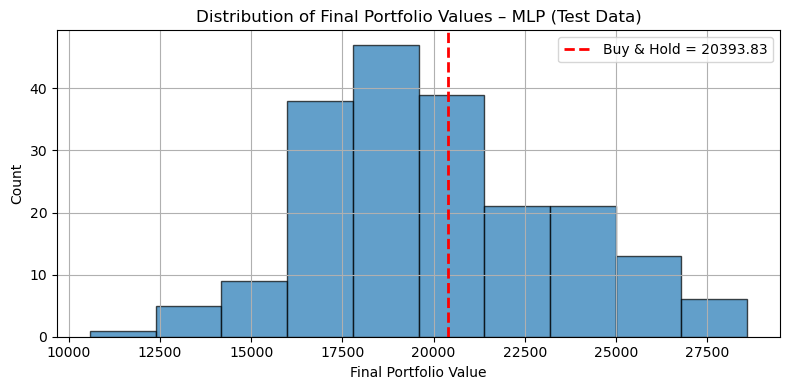

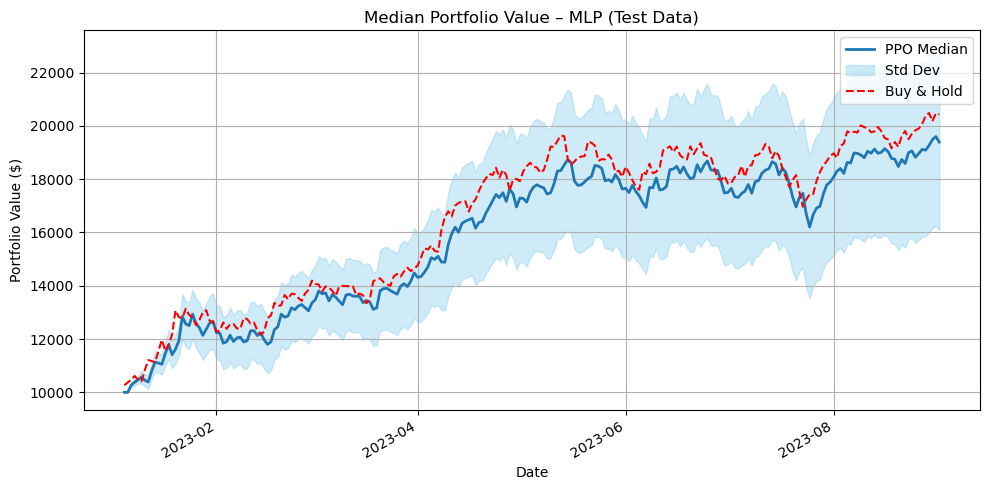

In [132]:
import yfinance as yf
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

tickers = ["AAPL", "MSFT", "GOOGL", "META", "AMZN", "TSLA", "NVDA"]
start, end = "2023-01-01", "2024-01-01"

# === Download and store raw test prices ===
raw_prices_test = {}
for t in tickers:
    df = yf.download(t, start=start, end=end)
    raw_prices_test[t] = df["Close"].values.astype(np.float32)

dates = df.index

# === Buy & Hold Benchmark on test data ===
bh_test = BuyAndHoldEnvironment(raw_prices_test)
bh_test.run(start_index=state_dim)
bh_final = bh_test.portfolio_values[-1]
bh_curve = bh_test.portfolio_values
bh_dates = pd.date_range(start=start, periods=len(bh_curve))

# === Normalization based on training stats ===
mean_price = {t: raw_prices[t].mean() for t in tickers}
std_price  = {t: raw_prices[t].std()  for t in tickers}

# === Run PPO agent on unseen test data ===
n_runs = 200
final_pf = []
ppo_trajectories = []

print("Running PPO (MLP – Closing Price) on Testing Data...\n")

for run in range(n_runs):
    env = MultiStockEnvironment(raw_prices_test, window_size=state_dim)
    state_dict = env.reset()
    done = False
    trajectory = [env.initial_cash]

    while not done:
        actions = {}
        for t in tickers:
            win = state_dict[t]
            norm_p = (win - mean_price[t]) / std_price[t]
            st = torch.tensor(norm_p, dtype=torch.float32).view(1, -1)
            a = get_action(st, w1, w2, w3a, log_std)[0].item()
            actions[t] = a

        state_dict, pv, done, _ = env.step(actions)
        trajectory.append(pv)

    final_val = trajectory[-1]
    final_pf.append(final_val)
    ppo_trajectories.append(trajectory)
    print(f"Run {run+1:2d}/{n_runs} → Final Portfolio Value: {final_val:.2f}")

# === Summary Statistics ===
mean_pf = np.mean(final_pf)
std_pf  = np.std(final_pf)
min_pf  = np.min(final_pf)
max_pf  = np.max(final_pf)
beats   = sum(p > bh_final for p in final_pf)
beat_pct = beats / n_runs * 100

print(f"\nSummary over {n_runs} runs:")
print(f"→ Mean Final Portfolio: {mean_pf:.2f} ± {std_pf:.2f}")
print(f"→ Min: {min_pf:.2f}, Max: {max_pf:.2f}")
print(f"→ Buy & Hold Final Portfolio: {bh_final:.2f}")
print(f"→ PPO beat Buy & Hold in {beat_pct:.1f}% of runs ({beats}/{n_runs})")

initial_cash = 10000.0
returns = [(pf / initial_cash - 1) * 100 for pf in final_pf]
avg_return = np.mean(returns)
std_return = np.std(returns)
min_return = np.min(returns)
max_return = np.max(returns)
bh_return = (bh_final / initial_cash - 1) * 100

print(f"\n→ Avg Agent Return: {avg_return:.2f}% ± {std_return:.2f}%")
print(f"→ Min: {min_return:.2f}%, Max: {max_return:.2f}%")
print(f"→ Buy & Hold Return: {bh_return:.2f}%")

# === Create output dir ===
os.makedirs("MLP_CP", exist_ok=True)

# === Save CSVs ===
pd.DataFrame({"final_portfolio_value": final_pf}).to_csv("MLP_CP/mlp_cp_test_final_portfolios.csv", index=False)

max_len = max(len(p) for p in ppo_trajectories)
for i in range(n_runs):
    last_val = ppo_trajectories[i][-1]
    ppo_trajectories[i] += [last_val] * (max_len - len(ppo_trajectories[i]))

pd.DataFrame(ppo_trajectories).T.to_csv("MLP_CP/mlp_cp_test_all_trajectories.csv", index=False)

# === Histogram Plot ===
plt.figure(figsize=(8, 4))
plt.hist(final_pf, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(bh_final, color='r', linestyle='--', linewidth=2, label=f'Buy & Hold = {bh_final:.2f}')
plt.title("Distribution of Final Portfolio Values – MLP (Test Data)")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("MLP_CP/mlp_cp_test_hist.png", dpi=600)
plt.show()

# === Median ± Std Plot ===
ppo_array = np.array(ppo_trajectories)
median_curve = np.median(ppo_array, axis=0)
std_curve    = np.std(ppo_array, axis=0)

x_dates = bh_dates[state_dim - 1 : state_dim - 1 + len(median_curve)]
min_len = min(len(x_dates), len(median_curve), len(bh_curve))
x_dates = x_dates[:min_len]
median_curve = median_curve[:min_len]
std_curve = std_curve[:min_len]
bh_curve = bh_curve[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(x_dates, median_curve, label='PPO Median', linewidth=2)
plt.fill_between(x_dates, median_curve - std_curve, median_curve + std_curve,
                 color='skyblue', alpha=0.4, label='Std Dev')
plt.plot(x_dates, bh_curve, 'r--', label='Buy & Hold')
plt.title("Median Portfolio Value – MLP (Test Data)")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig("MLP_CP/mlp_cp_test_median_std.png", dpi=600)
plt.show()
